In [44]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [45]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [46]:
import train_tabular_utils as tt
import cv_split_utils
import enums
from enums import ModelName
import data_utils
import param_tuning_utils as ptu

In [47]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "price"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSE
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.CatBoost
    NUM_TUNING_TRIALS = 2
    TUNE_ON_SINGLE_FOLD = True
    TUNE_STEPWISE = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False    
    USE_MANUAL_FEATURES = True
    USE_ORIGINAL_DATA = False    
    FEATURE_SELECTION_METHOD = "backward"
    NUM_CLASSES = None    

COLS_TO_LEAVE = ["id", "price", "kfold", "transmission_speed", "target_grp"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e9/"
    if Config.USE_MANUAL_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e9-fe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e9/"
    DATA_WRITEPATH = "/kaggle/working/"

In [48]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
        "device": "cuda",
        "tree_method": "hist"
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt",
        "device":  "cpu",
        #"gpu_platform_id": 0,
        #"gpu_device_id": 0
    },
    enums.ModelName.CatBoost: {
        "objective": "RMSE",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "RMSE",
        'grow_policy':  'Lossguide',
        'bootstrap_type': 'Poisson',
        'task_type': 'GPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [49]:
# For RandomForest
# tuned_model_params = {'n_estimators': 1300, 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}
# For CatBoost
tuned_model_params = {'learning_rate': 0.0026752932092600212, 'n_estimators': 4550, 'max_depth': 6, 'min_data_in_leaf': 73, 'num_leaves': 136, 'subsample': 0.9417643579568004, 'reg_lambda': 99.65892476752238, 'random_strength': 0.6286348851856994, 'early_stopping_rounds': 450, 'max_bin': 57}
# For XGBoost
# tuned_model_params = {'n_estimators': 1400, 'learning_rate': 0.10270166896064774, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 4.123490349502186, 'subsample': 0.5067185283456936, 'colsample_bytree': 0.7289930512882908, 'reg_alpha': 0.5971832077526927, 'reg_lambda': 9.433125479981229, 'early_stopping_rounds': 260}
# For LGBM
# tuned_model_params = {'learning_rate': 0.04384599885192124, 'n_estimators': 1850, 'max_depth': 4, 'min_data_in_leaf': 79, 'num_leaves': 20, 'min_child_weight': 1.3000000000000003, 'subsample': 0.6909074597205864, 'colsample_bytree': 0.7928274099493369, 'reg_lambda': 178.39029552790532, 'reg_alpha': 1.704574120515208, 'early_stopping_rounds': 490, 'max_bin': 184}

# tuned_model_params = None

In [50]:
high_resale_price_brands = ['Mercedes-Benz', 'Bentley', 'Aston', 'Jaguar', 'Tesla', 'Lamborghini', 'Land', 'RAM', 
                            'Cadillac', 'Alfa', 'Ferrari', 'Porsche', 'Bugatti', 'McLaren', 'Rolls-Royce', 'Lucid', 
                            'Maserati', 'Rivian', 'Genesis']

In [51]:
# if Config.USE_MANUAL_FEATURES and not Config.USE_ORIGINAL_DATA:
#     df_train = pd.read_csv(DATA_READPATH + "train_preprocessed.csv")
#     df_test = pd.read_csv(DATA_READPATH + "test_preprocessed.csv")        
#     # remove rows where price > 2000000
#     # df_train = df_train[df_train['price'] <= 2000000]
# elif Config.USE_MANUAL_FEATURES and Config.USE_ORIGINAL_DATA:
#     df_train = pd.read_csv(DATA_READPATH + "train_withorig_preprocessed.csv")
#     df_test = pd.read_csv(DATA_READPATH + "test_withorig_preprocessed.csv")
# else:
#     df_train = pd.read_csv(DATA_READPATH + "train.csv")
#     df_test = pd.read_csv(DATA_READPATH + "test.csv")
# # keep a copy of original train and test data for later use
# df_train_orig = df_train.copy()
# df_test_orig = df_test.copy()

In [52]:
def get_train_data():
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    if Config.USE_ORIGINAL_DATA:
        df_train_orig = pd.read_csv(DATA_READPATH + "used_cars.csv")
        df_train_orig[['milage', 'price']] = df_train_orig[['milage', 'price']].applymap(lambda x: int(re.sub("[^0-9]", "", x)))
        df_train_orig['milage'] = df_train_orig['milage'].astype('int64')
        df_train_orig['price'] = df_train_orig['price'].astype('int64')
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)        
    return df_train

In [53]:
df_train = get_train_data()
print(f"df_train.shape: {df_train.shape}")
df_test = pd.read_csv(DATA_READPATH + "test.csv")
df_test["price"] = 0
print(f"df_test.shape: {df_test.shape}")
df_combined = pd.concat([df_train, df_test],axis=0,ignore_index=True)
print("df_combined shape:", df_combined.shape )
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()
# # drop id column
# df_train = df_train.drop("id", axis=1)
# df_test = df_test.drop("id", axis=1)

df_train.shape: (188533, 13)
df_test.shape: (125690, 13)
df_combined shape: (314223, 13)


In [54]:
def update(df):    
    t = 100    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

df_train  = update(df_train)
df_test   = update(df_test)

In [55]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS,
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                n_bins=25)

In [56]:
imputation_config = None
# if Config.USE_MANUAL_FEATURES:
#     # Define imputation configuration
#     imputation_config = {
#         'horsepower': SimpleImputer(strategy="median"),
#         'capacity': SimpleImputer(strategy="most_frequent"),
#         'cylinders': SimpleImputer(strategy="most_frequent")
#     }

In [57]:
# df_train.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)
# df_test.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)
# if Config.USE_MANUAL_FEATURES:
#     df_train.fillna({"fuel": "Unknown"})
#     df_test.fillna({"fuel": "Unknown"})

In [58]:
# df_train["turbo"] = df_train["turbo"].astype(int)
# df_train["hybrid"] = df_train["hybrid"].astype(int)
#df_train["is_high_resale_price_brand"] = df_train["is_high_resale_price_brand"].astype(int)

In [59]:
# do not include 'id' column in the list of int columns
int_cols = [col for col in df_train.columns if df_train[col].dtypes == 'int64' and col not in COLS_TO_LEAVE]
float_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float64']
bool_cols = [col for col in df_train.columns if df_train[col].dtypes == 'bool']
cat_cols = [col for col in df_train.columns if df_train[col].dtypes in ['object', 'category'] and col not in COLS_TO_LEAVE]
feature_cols = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [60]:
print(feature_cols)
print(cat_cols)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [61]:
# Convert all categorical columns to string type
# df_train[cat_cols] = df_train[cat_cols].astype(str)
cat_encoders = None
# cat_encoders = {col: [
#                        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
#                        TargetEncoder(target_type="continuous")  
#                      ]
#                     for col in cat_cols
#                 }

In [62]:
# # preprocessing
preprocessor = None

In [63]:
def get_lgbm_tuning_params(trial):    
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 200),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20)
    }
    return {**model_static_params[enums.ModelName.LGBM], **params_dynamic}

In [64]:
lgbm_level_params_totune = {
    "1": ["learning_rate", "n_estimators", "max_depth"],
    "2": ["min_data_in_leaf", "num_leaves", "min_child_weight"],
    "3": ["subsample", "colsample_bytree", "reg_lambda", "reg_alpha", "early_stopping_rounds", "max_bin"]
}

lgbm_param_ranges = {
    'learning_rate': {'type': 'float', 'min_value': 0.005, 'max_value': 0.3, 'log': True},
    'n_estimators': {'type': 'int', 'min_value': 500, 'max_value': 5000, 'step': 50},
    'max_depth': {'type': 'int', 'min_value': 4, 'max_value': 20},
    'min_data_in_leaf': {'type': 'int', 'min_value': 5, 'max_value': 100},
    'num_leaves': {'type': 'int', 'min_value': 4, 'max_value': 256, 'step': 4},
    'min_child_weight': {'type': 'float', 'min_value': 0.1, 'max_value': 10, 'step': 0.2},
    'subsample': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'colsample_bytree': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'reg_lambda': {'type': 'float', 'min_value': 1, 'max_value': 300},
    'reg_alpha': {'type': 'float', 'min_value': 0, 'max_value': 5},    
    'early_stopping_rounds': {'type': 'int', 'min_value': 50, 'max_value': 500, 'step': 20},
    'max_bin': {'type': 'int', 'min_value': 32, 'max_value': 255}
}

lgbm_params_defaults = {
    'max_depth': 5,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'min_child_weight': 1.0,
    'subsample': 0.8,    
    'colsample_bytree': 0.8,
    'reg_lambda': 3,
    'reg_alpha': 0,
    'random_strength': 1,
    'early_stopping_rounds': 100,
    'max_bin': 255
}

In [65]:
cb_level_params_totune = {
    "1": ["learning_rate", "n_estimators"],
    "2": ["max_depth", "min_data_in_leaf", "num_leaves"],
    "3": ["subsample", "reg_lambda", "random_strength", "early_stopping_rounds", "max_bin"]
}

cb_param_ranges = {
    'learning_rate': {'type': 'float', 'min_value': 1e-3, 'max_value': 0.5, 'log': True},
    'n_estimators': {'type': 'int', 'min_value': 100, 'max_value': 10000, 'step': 100},
    'max_depth': {'type': 'int', 'min_value': 4, 'max_value': 20},
    'min_data_in_leaf': {'type': 'int', 'min_value': 5, 'max_value': 100},
    'num_leaves': {'type': 'int', 'min_value': 4, 'max_value': 256, 'step': 4},
    'subsample': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'reg_lambda': {'type': 'float', 'min_value': 1, 'max_value': 100},
    'random_strength': {'type': 'loguniform', 'min_value': 0.01, 'max_value': 5},
    'early_stopping_rounds': {'type': 'int', 'min_value': 50, 'max_value': 500, 'step': 20},
    'max_bin': {'type': 'int', 'min_value': 32, 'max_value': 255}
}

cb_params_defaults = {
    'max_depth': 6,
    'min_data_in_leaf': 1,
    'subsample': 0.8,
    # comment colsample_bylevel for GPU training
    #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
    'num_leaves': 96,
    'reg_lambda': 3,
    'random_strength': 1,
    'early_stopping_rounds': 100,
    'max_bin': 254
}

In [66]:
xgb_level_params_totune = {
    "1": ["learning_rate", "n_estimators", "max_depth"],
    "2": ["min_child_weight", "subsample", "colsample_bytree"],
    "3": ["reg_lambda", "reg_alpha", "early_stopping_rounds", "max_bin", "max_leaves", "gamma"]
}

xgb_param_ranges = {
    'learning_rate': {'type': 'float', 'min_value': 0.005, 'max_value': 0.3, 'log': True},
    'n_estimators': {'type': 'int', 'min_value': 100, 'max_value': 5000, 'step': 50},
    'max_depth': {'type': 'int', 'min_value': 4, 'max_value': 20},        
    'min_child_weight': {'type': 'int', 'min_value': 1, 'max_value': 20},
    'subsample': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'colsample_bytree': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'reg_lambda': {'type': 'float', 'min_value': 0.01, 'max_value': 10},
    'reg_alpha': {'type': 'float', 'min_value': 0.0, 'max_value': 10.0},   
    'max_leaves': {'type': 'int', 'min_value': 0, 'max_value': 256}, 
    'early_stopping_rounds': {'type': 'int', 'min_value': 10, 'max_value': 100},
    'max_bin': {'type': 'int', 'min_value': 32, 'max_value': 255},
    'gamma': {'type': 'float', 'min_value': 0.0, 'max_value': 10.0}
}

xgb_params_defaults = {
    'max_depth': 5,    
    'min_child_weight': 1,
    'subsample': 0.8,    
    'colsample_bytree': 0.8,
    'reg_lambda': 0,
    'reg_alpha': 0,    
    'early_stopping_rounds': 15,
    'max_bin': 255,
    'gamma': 0.0,
    'max_leaves': 0
}

In [67]:
def get_tuning_params(model_name):
    if model_name == enums.ModelName.LGBM:
        level_params_totune = lgbm_level_params_totune
        param_ranges = lgbm_param_ranges
        params_defaults = lgbm_params_defaults
    elif model_name == enums.ModelName.CatBoost:
        level_params_totune = cb_level_params_totune
        param_ranges = cb_param_ranges
        params_defaults = cb_params_defaults
    elif model_name == enums.ModelName.XGBoost:
        level_params_totune = xgb_level_params_totune
        param_ranges = xgb_param_ranges
        params_defaults = xgb_params_defaults
    return level_params_totune, param_ranges, params_defaults

In [68]:
if tuned_model_params is None:
    #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
    level_params_totune, param_ranges, params_defaults = get_tuning_params(Config.MODEL_TYPE)
    tuned_model_params = ptu.tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="minimize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            preprocessor=preprocessor,
                            df=df_train,
                            feature_cols=feature_cols,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS,
                            imputation_config=imputation_config,
                            cat_features=cat_cols,
                            cat_encoders=cat_encoders,
                            stepwise=Config.TUNE_STEPWISE,
                            level_params_totune=level_params_totune,
                            params_defaults=params_defaults,
                            static_params=model_static_params,
                            param_ranges=param_ranges
                        )
    print(f"Tuned model params: {tuned_model_params}")

In [69]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if tuned_model_params is not None:
    model_params = {**params_static, **tuned_model_params}
else:
    model_params = params_static

print(model_params)    

{'objective': 'RMSE', 'verbose': 0, 'random_seed': 42, 'eval_metric': 'RMSE', 'grow_policy': 'Lossguide', 'bootstrap_type': 'Poisson', 'task_type': 'GPU', 'learning_rate': 0.0026752932092600212, 'n_estimators': 4550, 'max_depth': 6, 'min_data_in_leaf': 73, 'num_leaves': 136, 'subsample': 0.9417643579568004, 'reg_lambda': 99.65892476752238, 'random_strength': 0.6286348851856994, 'early_stopping_rounds': 450, 'max_bin': 57}


In [71]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=None,
        df=df_train,
        feature_cols=feature_cols,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        imputation_config=imputation_config,
        cat_features=cat_cols,
        cat_encoders=cat_encoders
)

KeyboardInterrupt: 

In [23]:
# tt.persist(
#     model_name=Config.MODEL_TYPE, 
#     fold_metrics_model=fold_metrics_model, 
#     df_oof_preds=df_oof_preds, 
#     persist_model=Config.PERSIST_MODEL, 
#     output_path=DATA_WRITEPATH
# )

In [24]:
# perform missing values imputation for test data
if imputation_config is not None:
    tt.impute_missing_values(df_train, df_test, imputation_config)
# perform categorical encoding for test data
if cat_encoders is not None:
    for col, encoders in cat_encoders.items():    
        for encoder in encoders:
            df_train[[col]] = encoder.fit_transform(df_train[[col]], df_train[Config.TARGET_COL_NAME])
            df_test[[col]] = encoder.transform(df_test[[col]])

In [25]:
df_fold_test_preds = tt.get_test_preds(fold_metrics_model, df_test, feature_cols, preprocessor=None, num_folds=Config.NUM_FOLDS)
print(f"Completed prediction for {len(df_test)} test rows")

Completed prediction for 125690 test rows


In [26]:
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME] = df_fold_test_preds["test_preds"]
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_fold_test_preds.to_csv(DATA_WRITEPATH + f'df_test_preds_{Config.MODEL_TYPE}.csv',index=False)
df_submission.head()

,id,price
0,188533,16674.195503
1,188534,82041.502088
2,188535,56025.094234
3,188536,30598.599303
4,188537,27542.509359


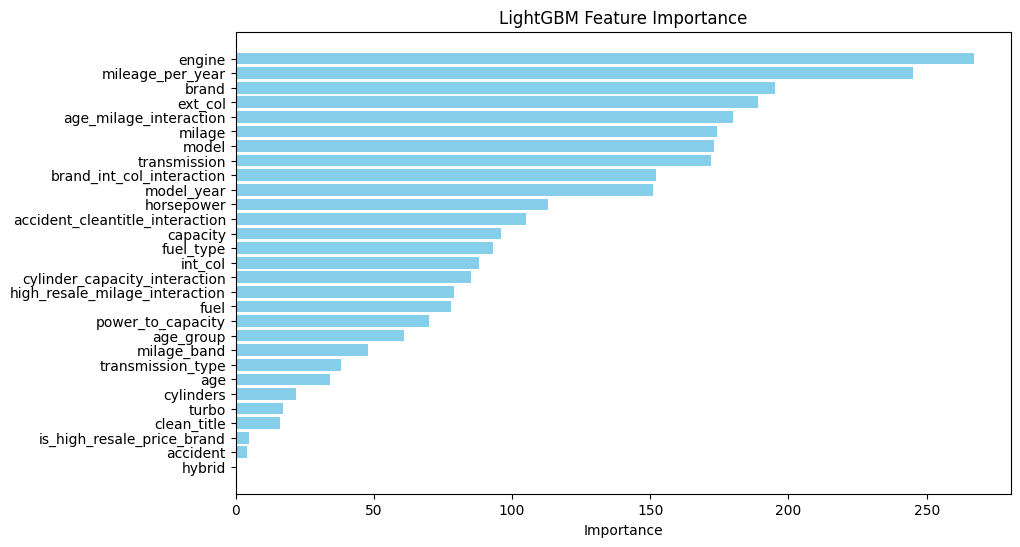

In [27]:
def get_feature_importance(model_name, model):
    if model_name == enums.ModelName.CatBoost:
        return model.get_feature_importance()
    if model_name in [enums.ModelName.LGBM, enums.ModelName.XGBoost]:
        return model.feature_importances_

# Get feature importance
model = fold_metrics_model[0][1]
# Create a DataFrame for visualization
df_feature_imp = pd.DataFrame({
    'f_name': feature_cols,
    'f_imp': get_feature_importance(Config.MODEL_TYPE, model)
})
# Sort the DataFrame by importance
df_feature_imp = df_feature_imp.sort_values(by='f_imp', ascending=False)
#data_utils.plot_feature_importance(df_feature_imp)
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_feature_imp['f_name'], df_feature_imp['f_imp'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'{Config.MODEL_TYPE} Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [28]:
# select the top 30 features as the base features
base_feature_count = None
# the set of constant features to be included in the model irrespective of the feature selection method
if Config.FEATURE_SELECTION_METHOD is not None:
    if Config.FEATURE_SELECTION_METHOD == "forward":
        if base_feature_count is None:
            base_features = df_feature_imp.f_name.values
        else:
            base_features = df_feature_imp.head(base_feature_count).f_name.values
    else:
        # for backward selection the entire feature set is the starting point
        base_features = df_feature_imp["f_name"].values    
    print(f"len(base_features) = {len(base_features)} base_features = {base_features}")        
    fold_metrics = [item[0] for item in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)
    print(f"\n base_val_score = {mean_metric}")
    best_score = mean_metric
    candidate_features = tt.get_candidate_features(df_feature_imp, Config.FEATURE_SELECTION_METHOD)
    print(f"\n len(candidate_features)={len(candidate_features)} candidate_features = {candidate_features}")
    selected_features = base_features

len(base_features) = 29 base_features = ['engine' 'mileage_per_year' 'brand' 'ext_col' 'age_milage_interaction'
 'milage' 'model' 'transmission' 'brand_int_col_interaction' 'model_year'
 'horsepower' 'accident_cleantitle_interaction' 'capacity' 'fuel_type'
 'int_col' 'cylinder_capacity_interaction'
 'high_resale_milage_interaction' 'fuel' 'power_to_capacity' 'age_group'
 'milage_band' 'transmission_type' 'age' 'cylinders' 'turbo' 'clean_title'
 'is_high_resale_price_brand' 'accident' 'hybrid']

 base_val_score = 72553.88642978897

 len(candidate_features)=29 candidate_features = ['hybrid' 'accident' 'is_high_resale_price_brand' 'clean_title' 'turbo'
 'cylinders' 'age' 'transmission_type' 'milage_band' 'age_group'
 'power_to_capacity' 'fuel' 'high_resale_milage_interaction'
 'cylinder_capacity_interaction' 'int_col' 'fuel_type' 'capacity'
 'accident_cleantitle_interaction' 'horsepower' 'model_year'
 'brand_int_col_interaction' 'transmission' 'model' 'milage'
 'age_milage_interaction' 'e

In [29]:
if Config.FEATURE_SELECTION_METHOD is not None:
    selected_features, unselected_features = tt.feature_selection(
        feature_selection_method=Config.FEATURE_SELECTION_METHOD,
        candidate_features=candidate_features,
        selected_features=selected_features,
        model_params=model_params,
        df_train=df_train,        
        preprocessor=preprocessor,
        imputation_config=imputation_config,
        cat_encoders=cat_encoders,
        num_folds=Config.NUM_FOLDS,
        metric=Config.METRIC,
        cat_features=None,
        target_col_name=Config.TARGET_COL_NAME,
        single_fold=False,
        model_name=Config.MODEL_TYPE,
        metric_minimize=True,
        best_score_initial=best_score
    )

FEATURE SELECTION METHOD = backward
feature not selected = hybrid | cur_val_score = 72602.54257967765 | best_score = 72553.88642978897
feature not selected = accident | cur_val_score = 72609.33868003305 | best_score = 72553.88642978897
feature not selected = is_high_resale_price_brand | cur_val_score = 72594.4986917693 | best_score = 72553.88642978897
feature not selected = clean_title | cur_val_score = 72620.4438479786 | best_score = 72553.88642978897
feature not selected = turbo | cur_val_score = 72640.93529401749 | best_score = 72553.88642978897
feature not selected = cylinders | cur_val_score = 72627.60508800429 | best_score = 72553.88642978897
feature not selected = age | cur_val_score = 72611.2369083538 | best_score = 72553.88642978897
feature not selected = transmission_type | cur_val_score = 72635.984604335 | best_score = 72553.88642978897
feature not selected = milage_band | cur_val_score = 72629.02287051742 | best_score = 72553.88642978897
feature not selected = age_group | c

In [31]:
print(f"selected_features = {selected_features}")

selected_features = ['engine' 'mileage_per_year' 'brand' 'ext_col' 'age_milage_interaction'
 'milage' 'model' 'transmission' 'brand_int_col_interaction' 'model_year'
 'horsepower' 'accident_cleantitle_interaction' 'capacity' 'fuel_type'
 'int_col' 'cylinder_capacity_interaction'
 'high_resale_milage_interaction' 'fuel' 'power_to_capacity' 'age_group'
 'milage_band' 'transmission_type' 'age' 'cylinders' 'turbo' 'clean_title'
 'is_high_resale_price_brand' 'accident' 'hybrid']


In [36]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=None,
        df=df_train,
        feature_cols=selected_features,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        imputation_config=imputation_config,
        cat_features=None,
        cat_encoders=cat_encoders
)

Fold 0 - LightGBM - RMSE : 72234.94524409149
Fold 1 - LightGBM - RMSE : 74129.89395206542
Fold 2 - LightGBM - RMSE : 72358.21020574243
Fold 3 - LightGBM - RMSE : 71957.55915911356
Fold 4 - LightGBM - RMSE : 72241.83780772777
LightGBM metric=RMSE CV score = 72588.7278678341
LightGBM Mean RMSE = 72584.48927374813, std = 783.8507843783434
CPU times: user 1min 36s, sys: 340 ms, total: 1min 36s
Wall time: 28.4 s


In [ ]:
import shap

# Assume `model` is a trained model and `X_train` is the training data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train[feature_cols])
shap_interaction_values = explainer.shap_interaction_values(df_train[feature_cols])

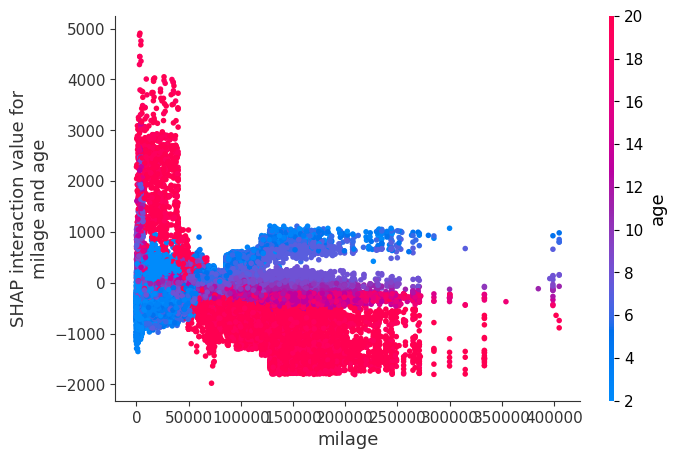

In [100]:
# Visualize interaction for two features
shap.dependence_plot(('milage', 'age'), shap_interaction_values, df_train[feature_cols])

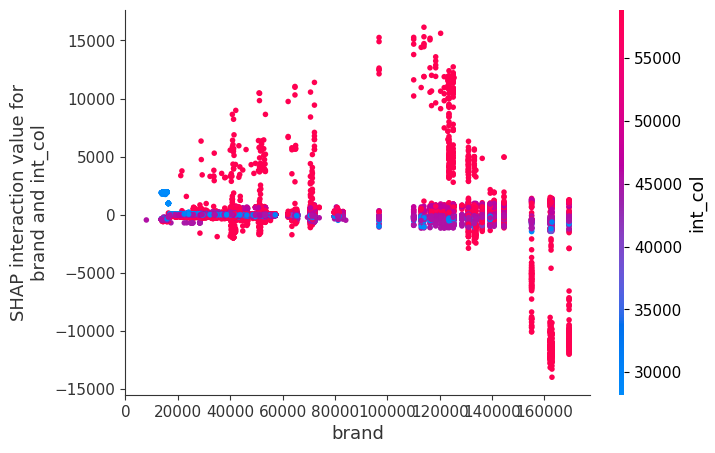

In [98]:
# Visualize interaction for two features
shap.dependence_plot(('brand', 'int_col'), shap_interaction_values, df_train[feature_cols])

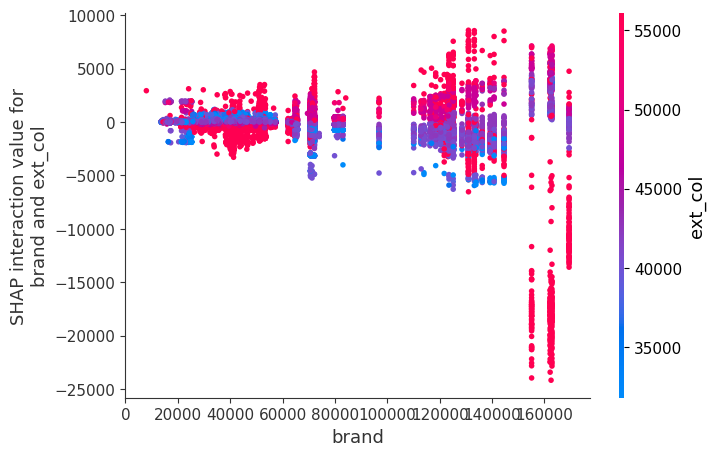

In [105]:
shap.dependence_plot(('brand', 'ext_col'), shap_interaction_values, df_train[feature_cols])

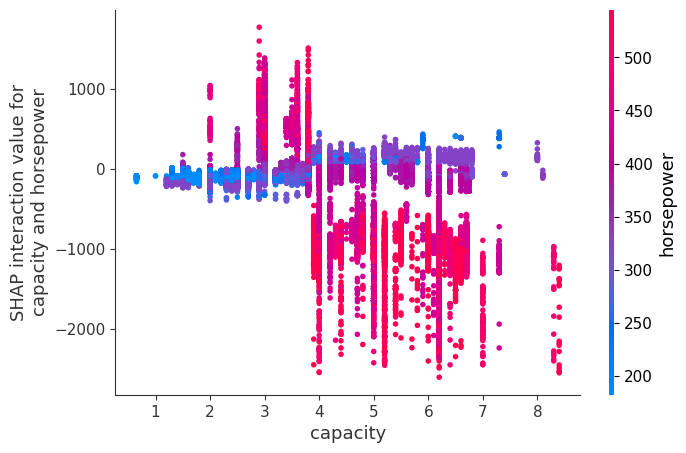

In [103]:
shap.dependence_plot(('capacity', 'horsepower'), shap_interaction_values, df_train[feature_cols])

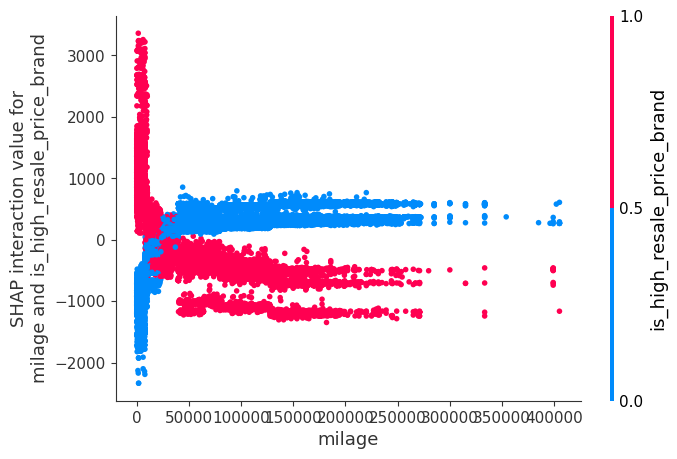

In [112]:
shap.dependence_plot(('milage', 'is_high_resale_price_brand'), shap_interaction_values, df_train[feature_cols])

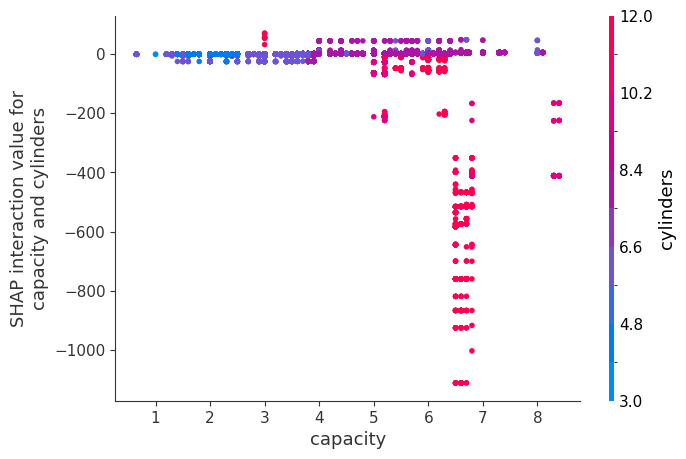

In [113]:
shap.dependence_plot(('capacity', 'cylinders'), shap_interaction_values, df_train[feature_cols])

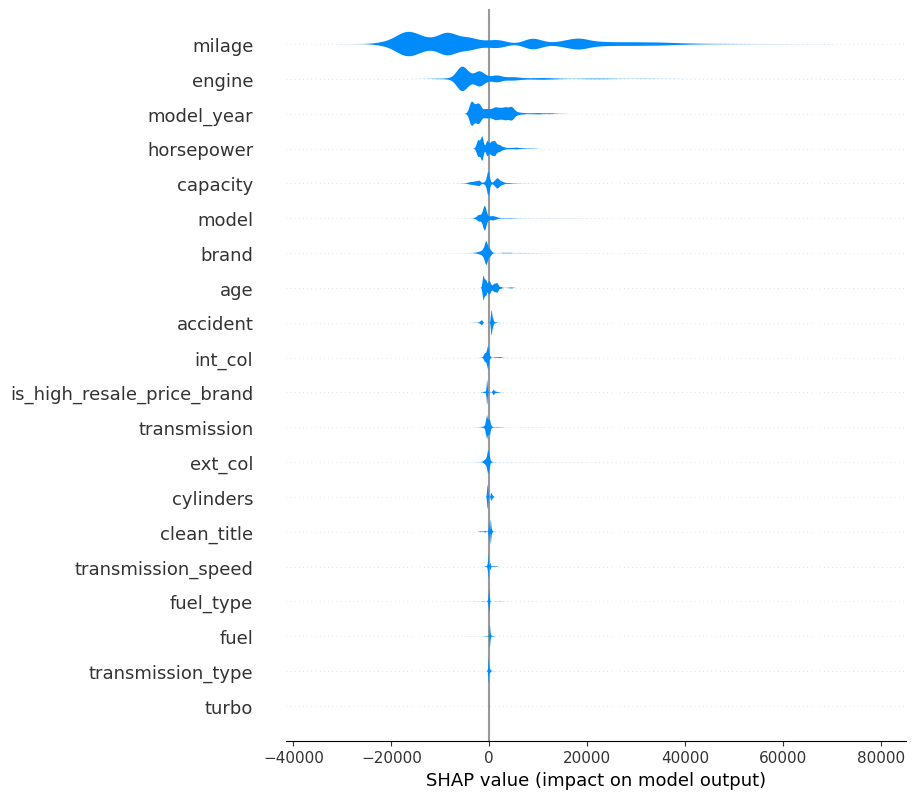

In [110]:
shap.plots.violin(shap_values, feature_names=feature_cols)

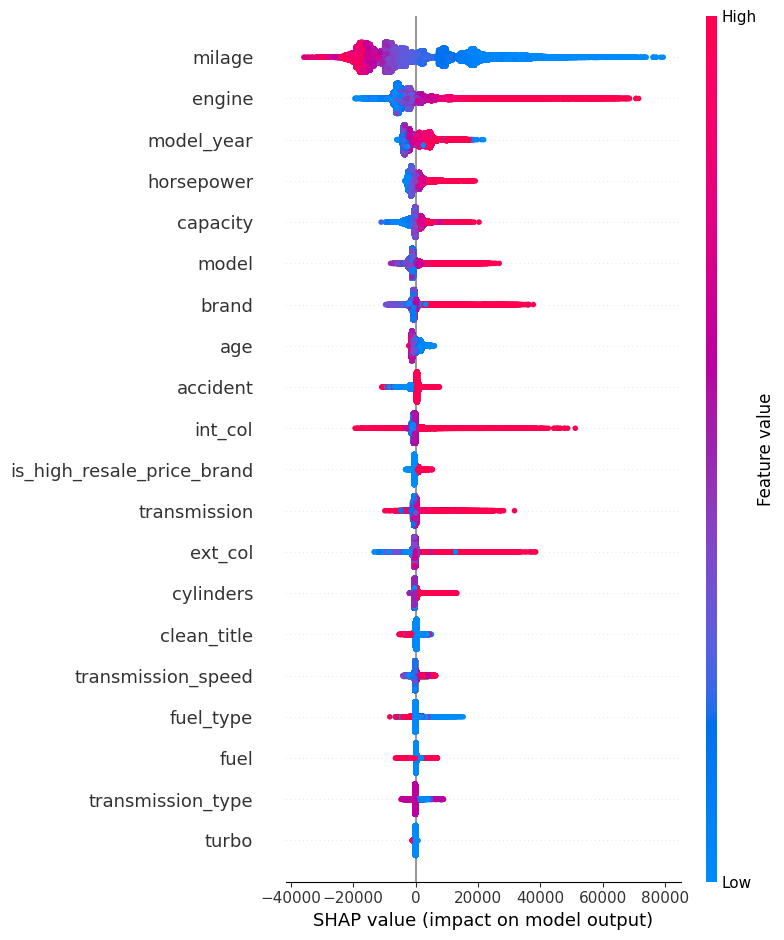

In [106]:
shap.summary_plot(shap_values, df_train[feature_cols])